In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import os

# Reading data

In [2]:
# Here, I separated environment folder with data folder, so I can work on smaller sample of data when developing and then resue the same code in production.

# folder where data exists
data_folder = './data'
# the environment folder 
env_folder = 'prod' 

file_path = os.path.join(data_folder, env_folder)

file_name = 'errands.parquet'

In [3]:
# Reading the data from given environment as a datafframe 
df_errands = pd.read_parquet( os.path.join(file_path,  file_name))

In [4]:
# List to document what categorical columns can be encoded
lst_cat_col_low_freq = []
lst_cat_col_mid_freq = []

# Exploring Errands

In [5]:
# Getting the head of errand dataframe
df_errands.head(5)

,order_number,errand_id,created,errand_category,errand_type,errand_action,errand_channel,is_test_errand
0,24770FC,52497975,2023-12-31 08:59:49,6: Payment questions,2: Payment not conf - CC,1: Info provided,1: Phone In,0
1,2479LIP,52502839,2023-12-31 11:36:31,6: Payment questions,3: Payment not conf - bank,1: Info provided,1: Phone In,0
2,247BO81,52520705,2024-01-01 00:02:32,6: Payment questions,6: No order but charged / charged twice / rese...,1: Info provided,19: Chat,0
3,247BZ9A,52520962,2024-01-01 00:23:39,9: Other services / products,3: Other airline services,7: Other,19: Chat,0
4,247BZDY,52521010,2024-01-01 00:28:26,5: Document & travel info,1: Have no document,6: Other,19: Chat,1


In [6]:
# filtering out test data
df_errands = df_errands[df_errands['is_test_errand']==0]

In [7]:
# Checking dataset to see if there is any null value
df_errands.isnull().sum(axis=0)

order_number          0
errand_id             0
created               0
errand_category       0
errand_type           3
errand_action      2184
errand_channel        0
is_test_errand        0
dtype: int64

In [8]:
# Getting more information about the errand dataframe
df_errands.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2680892 entries, 0 to 2885295
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   order_number     object
 1   errand_id        int64 
 2   created          object
 3   errand_category  object
 4   errand_type      object
 5   errand_action    object
 6   errand_channel   object
 7   is_test_errand   int64 
dtypes: int64(2), object(6)
memory usage: 184.1+ MB


In [9]:
# checking neumerical columns for errand dataframe
df_errands.describe()

,errand_id,is_test_errand
count,2.680892e+06,2680892.0
mean,5.833055e+07,0.0
std,4.108381e+06,0.0
min,5.249798e+07,0.0
25%,5.537976e+07,0.0
50%,5.730680e+07,0.0
75%,6.019765e+07,0.0
max,7.330838e+07,0.0


In [10]:
# Getting list of columns for errand dataframe
print(
    'List of columns:', 
    ', '.join(list(df_errands.columns)) 
     )

List of columns: order_number, errand_id, created, errand_category, errand_type, errand_action, errand_channel, is_test_errand


**Features description:**

* **errand_id**: A unique identifier for each customer contact (primary key)
* **order_number** Foreign key to orders (shall be converted)
    * **order_id**: The identifier of the order associated with this contact. It uses a base-36 format. (foreign key)
* **created**: The date and time the customer contact occurred. 
* **errand_category**: The general topic of the contact, such as rebooking, cancellation, ancillary services, etc.
* **errand_type**:  Provides more specific details about the contact within a category. For example, within Rebooking, it might specify No Flexible Ticket or Against Connection Guarantee
* **errand_action**: The action taken by the agent in response to the customer's request
* **errand_channel**: The communication channel used by the customer (e.g., email, phone,chat)
* **is_test_errand**: Sounds like it is for testing purpose, shall be analyzed

<b><font color='red'>Adding Feature: order_id</font></b>

Order id shall be calculated based on order Number: 

In [11]:
# I decode order_number since it is a base-36 format and add this value to a new column named order_id
df_errands['order_id'] = df_errands['order_number'].apply(lambda x: int(x, 36))

In [12]:
# changing data type of created to datetime
df_errands['created'] = pd.to_datetime(df_errands['created'], errors='raise')

In [13]:
# Checking the time window of data
print(
    'The start and end date of errands are ', 
    df_errands['created'].min(), 
    ' and ',
    df_errands['created'].max(),
    ', meaning that the data is recorded over ',
    df_errands['created'].max() - df_errands['created'].min()
)

The start and end date of errands are  2023-12-31 08:59:49  and  2024-12-19 00:06:21 , meaning that the data is recorded over  353 days 15:06:32


In [14]:
# It seems that there are errands recorded before order creation??

In [15]:
# Checking how many errands are created before order creation time
df_errands[df_errands['created']<'2024-01-01']

,order_number,errand_id,created,errand_category,errand_type,errand_action,errand_channel,is_test_errand,order_id
0,24770FC,52497975,2023-12-31 08:59:49,6: Payment questions,2: Payment not conf - CC,1: Info provided,1: Phone In,0,4607513832
1,2479LIP,52502839,2023-12-31 11:36:31,6: Payment questions,3: Payment not conf - bank,1: Info provided,1: Phone In,0,4607634481


In [16]:
# Also Errands are recorded much longer that order creation, shall be investigated

In [17]:
# Checking count of values for each errand category
df_errands['errand_category'].value_counts()

2: Cancellation / refund                       650659
1: Rebooking                                   624523
18: Schedule change                            457044
5: Document & travel info                      324104
4: Change of name & passenger info             176551
43: No response                                136635
7: Baggage                                     131324
6: Payment questions                            46100
8: Seating                                      42053
9: Other services / products                    38980
41: Call disconnected                           15037
3: Claim wrong itinerary/dupe                    8932
13: Language problem                             8535
10: Force Majeure                                6722
25: Other Booking.com products                   4159
11: Site support                                 2316
46: No information provided                      1850
14: FL Fraud errands process                     1256
20: Ancillary team          

<b><font color='green'>Encodabale column: errand_category</font></b>

In [18]:
# I append 'errand_category' to the list of middle frequencies columns
lst_cat_col_mid_freq.append('errand_category')

In [19]:
# Checking count of values for each errand type
df_errands['errand_type'].value_counts()

1: No Flexible Ticket         459075
1: Ask about cxnl rules       450383
2: We have inf. about SC      227403
2: Already cxnl               145943
1. Customer not reached       136635
                               ...  
14: Lock Your Price                1
3. FM                              1
23: Cabin Baggage                  1
33: Cancellation Guarantee         1
21: Supervisor Call                1
Name: errand_type, Length: 256, dtype: int64

In [20]:
len(df_errands['errand_type'].unique())

257

In [21]:
# It seems that every errand type belongs to one category
len(df_errands[['errand_category', 'errand_type']].drop_duplicates())

257

In [22]:
# Checking count of values for each errand action
df_errands['errand_action'].value_counts()

3: No change made                          361853
1: Info provided                           190386
3: Not cxnl reservation                    186354
1: Chat disconnected                       136635
1: Cnxl reservation                        120750
                                            ...  
4: Incorrect configuration – Refund             1
2: Review Sent to Support                       1
4: CR                                           1
3:Refund rejected                               1
11: Follow up with internal departments         1
Name: errand_action, Length: 383, dtype: int64

In [23]:
# check if every action starts with number: etc? (yes)
df_errands[~df_errands['errand_action'].fillna('1. ').str.match('^\d+.*')]

,order_number,errand_id,created,errand_category,errand_type,errand_action,errand_channel,is_test_errand,order_id


<b><font color='red'>Adding Feature: errand_action_code, errand_action_name</font></b>

In [24]:
# Extracting starting digits from errand_action and add the extracted digit to a column named errand_action_code
df_errands['errand_action_code'] = df_errands['errand_action'].str.extract('(^\d+)')

In [25]:
# replacing the starting digit from errand_action and add the extracted string to a column named errand_action_name
df_errands['errand_action_name'] = df_errands['errand_action'].str.replace('^\d+:\s*', '', regex=True)

In [26]:
# Checking count of values for each errand channel
df_errands['errand_channel'].value_counts()

19: Chat           1170684
1: Phone In         850534
2: Mail In          220021
34: SC Phone in     188015
39: SC Chat         187006
35: SC Mail In       64632
Name: errand_channel, dtype: int64

Text(0.5, 1.0, 'Distribution of errand channel')

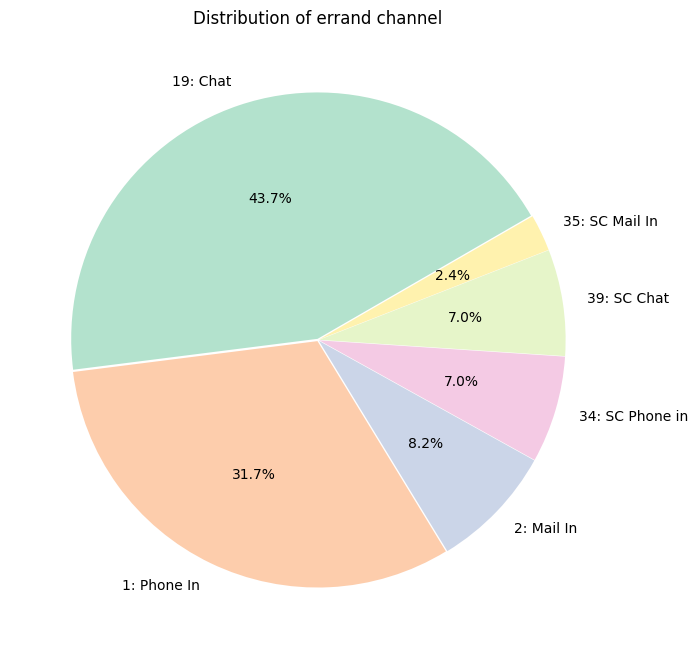

In [27]:
# Distribution of errand channel
plt.figure(figsize = (10, 8))

explode = []

for i in range (len(df_errands['errand_channel'].unique())):
    explode.append(0.005)

plt.pie(df_errands['errand_channel'].value_counts(), labels = df_errands['errand_channel'].value_counts().index , colors=plt.cm.Pastel2.colors, startangle = -330, autopct='%1.1f%%', explode = tuple(explode))

plt.title('Distribution of errand channel', fontsize = 12)


<b><font color='green'>Encodabale column: errand_channel</font></b>

In [28]:
# I append 'errand_channel' to the list of low frequencies columns
lst_cat_col_low_freq.append('errand_channel')

Text(0.5, 1.0, 'Count of each errand category')

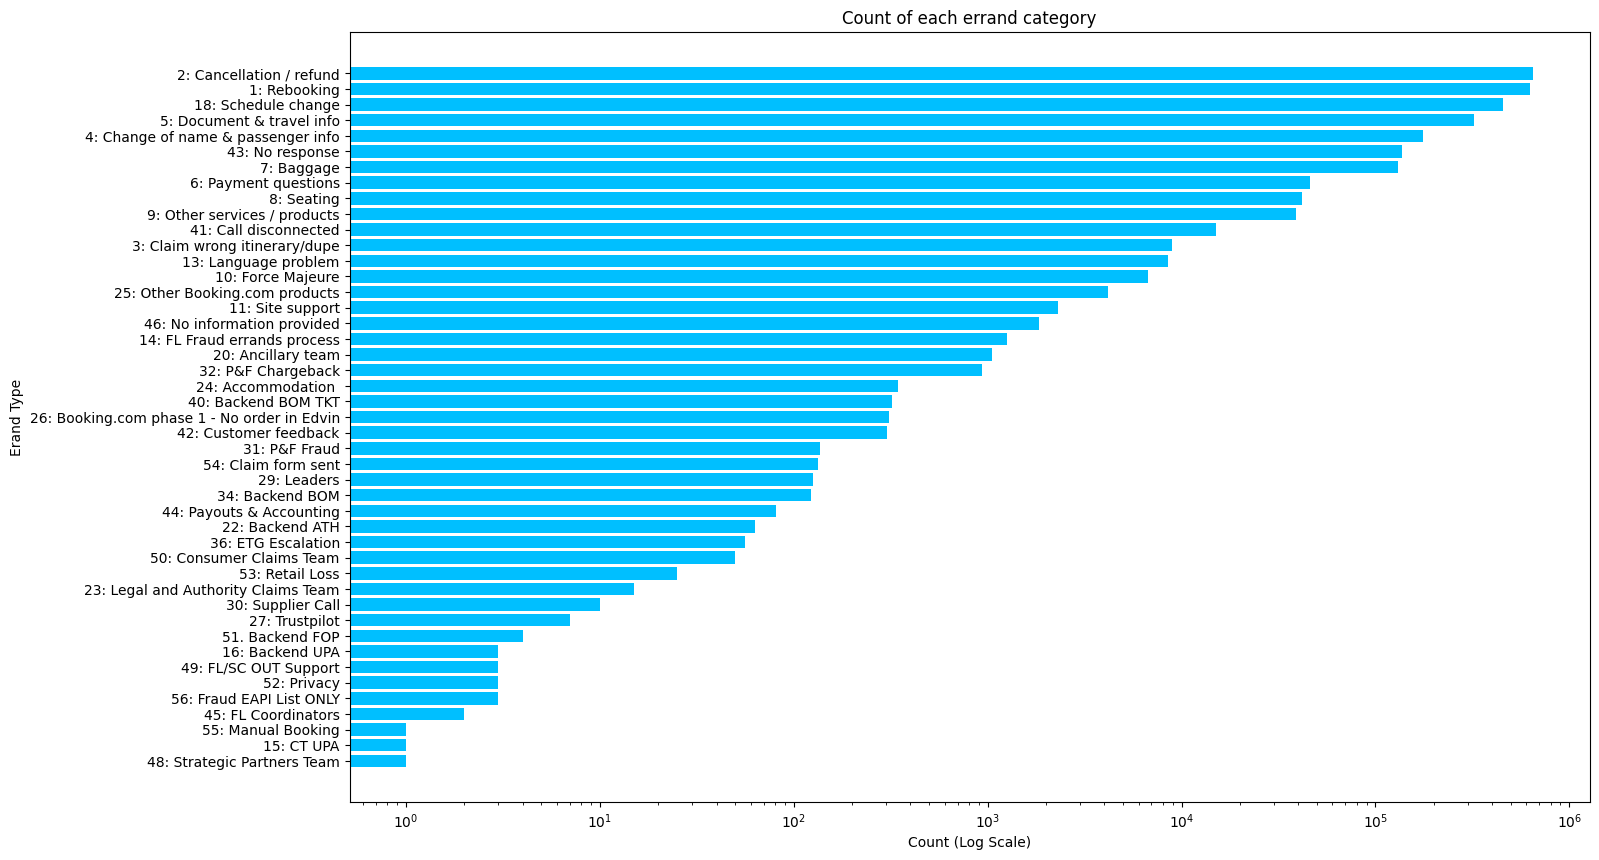

In [29]:
# Visualizing count of each errand category per category
errand_category_grouped = df_errands['errand_category'].value_counts().reset_index(name='count').rename(columns={'index': 'errand_category'}).sort_values(by='count', ascending=False).sort_values(by='count')

plt.figure(figsize=(16, 10))

plt.barh(errand_category_grouped['errand_category'], errand_category_grouped['count'], color = 'deepskyblue')  

plt.xscale('log')
plt.xlabel('Count (Log Scale)')
plt.ylabel('Erand Type')
plt.title('Count of each errand category')

In [30]:
# Checking count of values for is_test_errand
df_errands['is_test_errand'].value_counts()

0    2680892
Name: is_test_errand, dtype: int64

In [31]:
# saving the transformed data for upcoming notebooks
df_errands.to_parquet(os.path.join(file_path, 'cleaned_errands.parquet'))